This is the third part of a series of notebooks about practical time series methods:
* [Part 1: the basics](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics)
* [Part 2: smoothing methods](https://www.kaggle.com/konradb/practical-time-series-part-2-vintage-methods) 
* [Part 3: ARMA and friends](https://www.kaggle.com/konradb/practical-time-series-pt-3-arma-and-friends) - this notebook
* [Part 4: Prophet](https://www.kaggle.com/konradb/practical-time-series-pt-4-prophet)

The notebook is split into three sections: we introduce the basic framework of linear processes, then present extensions and finally demonstrate how to solve a prediction problem from scratch. 

* [Basic linear processes](#section-one)
* [Beyond ARMA](#section-two)
* [Full pipeline](#section-three)


As before, we begin by importing the required packages

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# Whatever my personal feelings on the matter, Excel is still used as a data source in a lot of places - so we need to be able to read it 
!pip install xlrd

     |████████████████████████████████| 96 kB 1.0 MB/s 


In [3]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Basic linear processes

Just to indulge my inner nerd, I will go top-down in this one and start from a high level definition - because why not :-) A linear process is a time series $X_t$ defined by:
\begin{equation}
    X_t = \sum_{u = -\infty}^{\infty} \psi_u \epsilon_{t-u}
\end{equation}
where $\epsilon_t$ is a white noise series and 
\begin{equation}
\sum_{u = -\infty}^{\infty} \left|\psi_u \right|^2 < \infty
\end{equation}


Translated to plain English:
* (in our context) white noise a serially uncorrelated sequence of random variables with zero mean and finite variance. For a general definition (and the origin of the color convention) I can recommend the Wikipedia entry: https://en.wikipedia.org/wiki/White_noise

* it is a linear combination - potentially infinite and depending on both past and present - of a white noise series

* in the real world it has to be causal $\implies$ depending on a finite number of past values

* it is a unified framework for handling different types of data generating processes

* for the mathematically inclided person reading this: huge parts of the theory behind ARMA processes pop up as special cases / corrolaries from results in functional analysis, specifically the [Hilbert projection theorem](https://en.wikipedia.org/wiki/Hilbert_projection_theorem) and [spectral theorem](https://en.wikipedia.org/wiki/Spectral_theorem); the requirement on sum of squared values being finite correspond to the $l_2$ space for our sequence: https://en.wikipedia.org/wiki/Lp_space

* only needs second order statistics (variance) $\rightarrow$ works best for elliptical distributions (e.g. Gaussian)



## AR processes

The simplest (non-trivial) example of a linear process is an autoregressive process of order $p$:
    \begin{equation}
    X_t = \sum_{i= 1}^p \phi_i X_{t-i} + \epsilon_t
    \end{equation}
    
Unpacking the formula:
1. Natural extension of a multiple linear regression model: we forecast the variable of interest using a linear combination of past values of the variable (lagged values act as predictors). The term \textit{auto}regression reflects the fact that we are regressing the variable on (version of) itself
2. The single exponential smoothing method (described [here](https://www.kaggle.com/konradb/practical-time-series-pt-2-smoothing-methods?scriptVersionId=68281131) ) can be viewed as a special case of an autoregressive process of order 1
3. Easy to estimate parameters and forecast 


Now that we have defined (and hopefully understood) what an AR process is, let's have a look at how to identify one. This is relevant if we need to decide whether an autoregressive process is a right kind of model for a particular dataset. For the sake of demonstration, we will use simulated data, where the data generating process is:
    \begin{equation}
    X_t = 0.9 X_{t-1} + \epsilon_t
    \end{equation}
    
Observe in the codeblock below that the coefficient changes sign - this is because of the notational convention in statsmodels, where we read the coefficients in order defined by the characteristic polynomial (more on that below):
    \begin{equation}
    X_t - 0.9 X_{t-1} = \epsilon_t
    \end{equation}


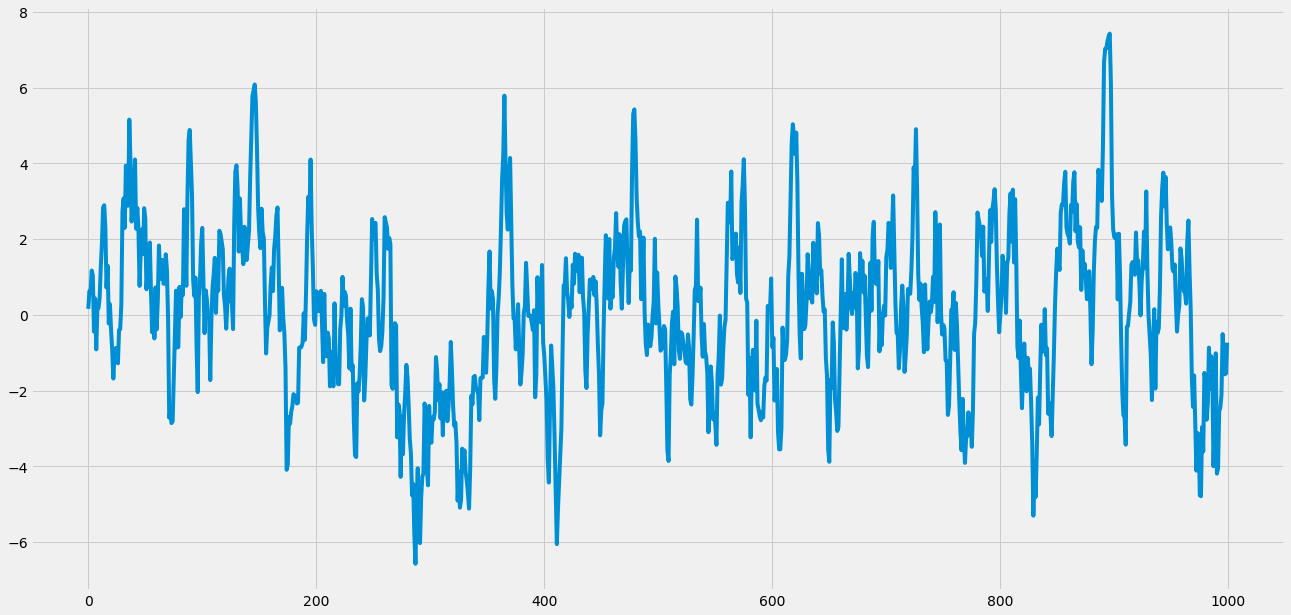

In [4]:
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

A fast technique for deciding if AR is the right kind of model is to examine the autocorrelation and partial autocorrelation functions (described [here](https://www.kaggle.com/konradb/practical-time-series-pt-1-the-basics#Dependence)):

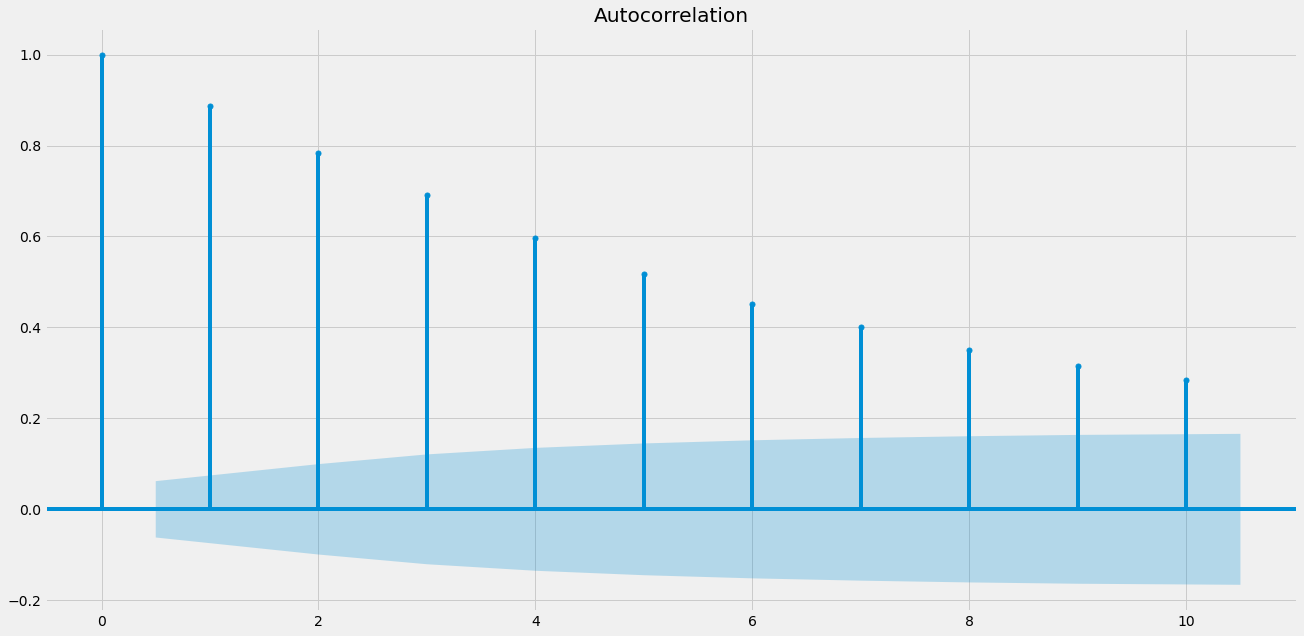

In [5]:
plot_acf(simulated_data_1, lags = 10)
plt.show()

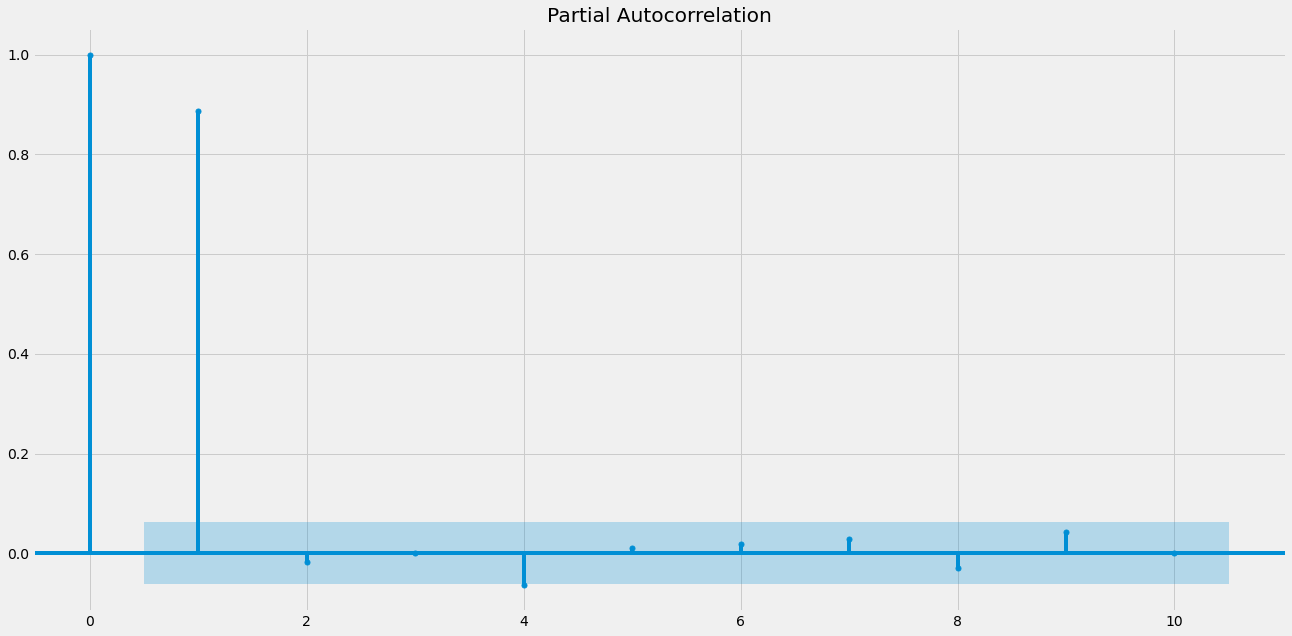

In [6]:
plot_pacf(simulated_data_1, lags = 10)
plt.show()

Intuition for identification:
* process memory: direct and indirect dependence information
* ACF for AR(p): strong until lag p, trailing off afterwards
* PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.



## MA processes

An autoregressive model expresses the forecast variable as a linear combination of past realizations of itself and the same idea can be applied to past forecast errors: a moving average process of order $q$ is defined by the relationship:
    
\begin{equation}
X_t = \epsilon_t + \sum_{i = 1}^q \theta_i \epsilon_{t-i}
\end{equation}

where $\epsilon_t$ is a white noise series.
  
Let's repeat the identification exercise from before:
    \begin{equation}
    X_t = \epsilon_t + 0.9  \epsilon_{t-1}
    \end{equation}


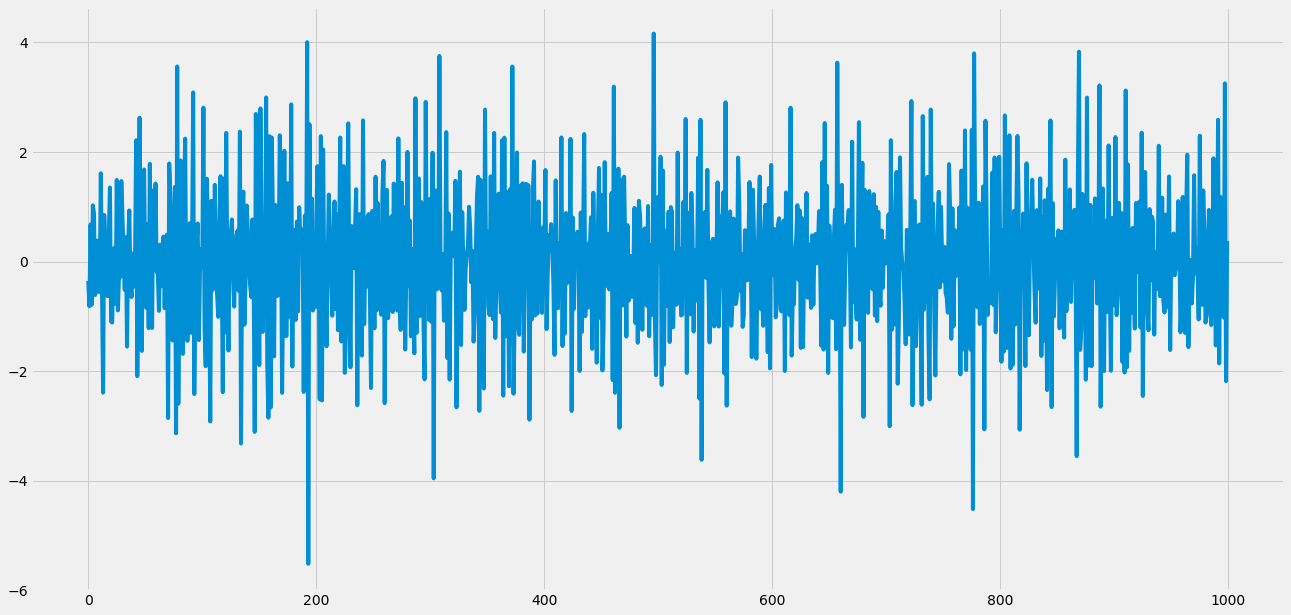

In [7]:
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

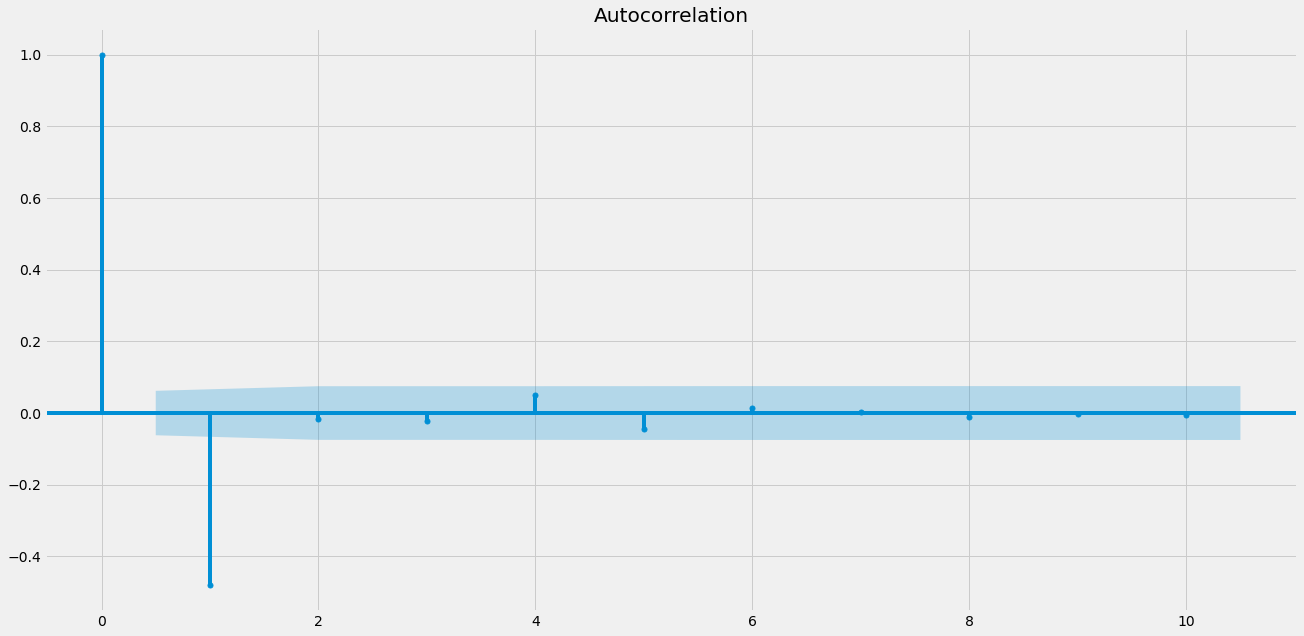

In [8]:
plot_acf(simulated_data_1, lags = 10)
plt.show()

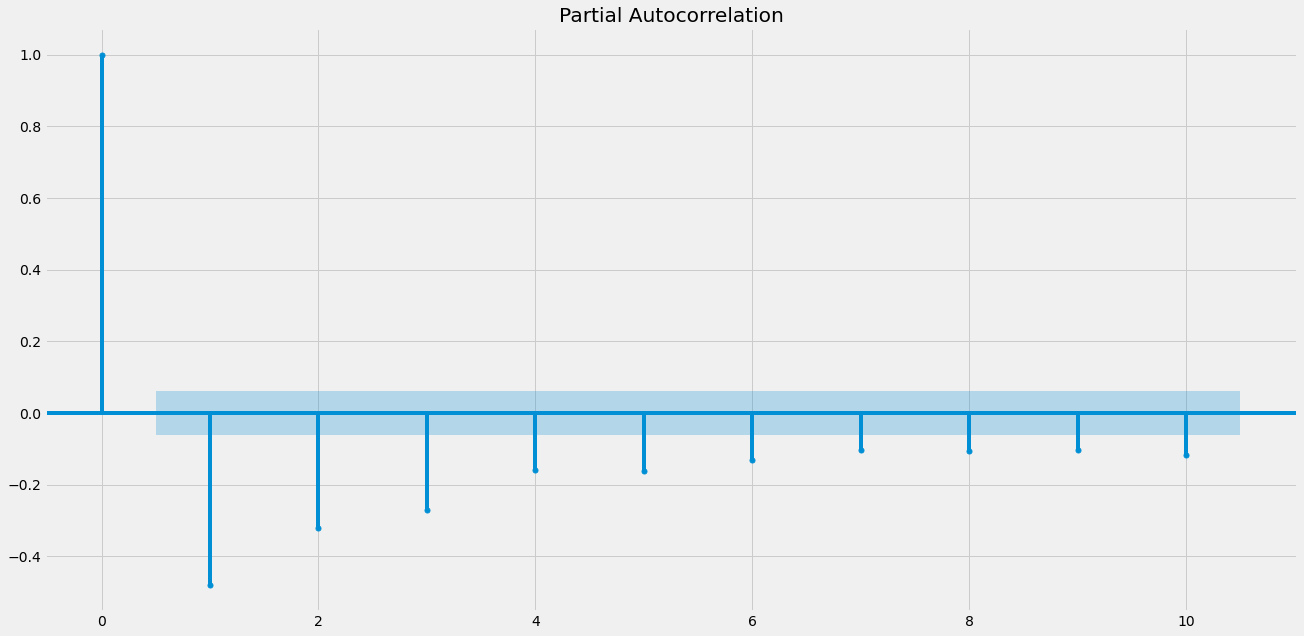

In [9]:
plot_pacf(simulated_data_1, lags = 10)
plt.show()

Intuition for identification:
* **MA model corrects future forecasts based on errors made on recent forecasts.**
* ACF for MA(k) series: to show a strong correlation with recent values up to the lag of k, then a sharp decline 
* PACF: strong relationship to the lag k and a trailing off of correlation from the lag onwards.

## ARMA

We have an autoregressive component and a moving average one, so it is quite natural to combine those two types of dynamics into a single model: ARMA(p,q) series satisfies the relationship:

\begin{equation}
X_t = \sum_{i=1}^p \phi_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t
\end{equation}

where our predictors on the right hand side include **both lagged values of the series and lagged errors**, $p$ is the order the autoregressive part and $q$ is the order of the moving average component.

Some observations:
1. if an ARMA(p,q) model is stationary (see [module 1](https://www.kaggle.com/konradb/practical-time-series-pt-1-the-basics#Stationarity) for a refresher), it can be represented as an infinite AR series
\begin{equation}    
    X_t = \sum_{u=1}^\infty \pi_u X_{t-u} + \epsilon_t
\end{equation}

2. this allows for estimation via maximum likelihood and a simple recursive forecast:
\begin{equation}
    \hat{X}_{T+1} = \sum_{u=1}^\infty \hat{\pi}_u X_{T+1 - u}
\end{equation}

In practice: Kalman filter (incoming in subsequent modules).

3. Stationarity of the ARMA(p,q) process is established by analyzing the characteristic polynomial. There is quite a substantial body of theoretical work behind this idea, but the word "practical" is there for a reason in the title of this series :-) so a crash-course argument would go like this:

    * given ARMA(p,q) series defined by the equation above, we can write its characteristic polynomial 
    
    \begin{equation}
    P(z) = 1 - \phi_1 z - \ldots - \phi_p z^p
    \end{equation}
    
    * if we look for solutions in complex (as opposed to real numbers) domain, the equation P(z) = 0 has $p$ solutions $z_1, \ldots, z_p$
    
    * if $|z_i| >1$ for all $i$ then the underlying model is stationary
    

## Forecasting with ARMA

Let's put our newly introduced framework to the test and actually predict something.

### Case 1

The first dataset we look is the quarterly change in the aggregate savings level in the United States - the data is sourced from FRED: https://fred.stlouisfed.org/series/A191RP1Q027SBEA.

<AxesSubplot:xlabel='date'>

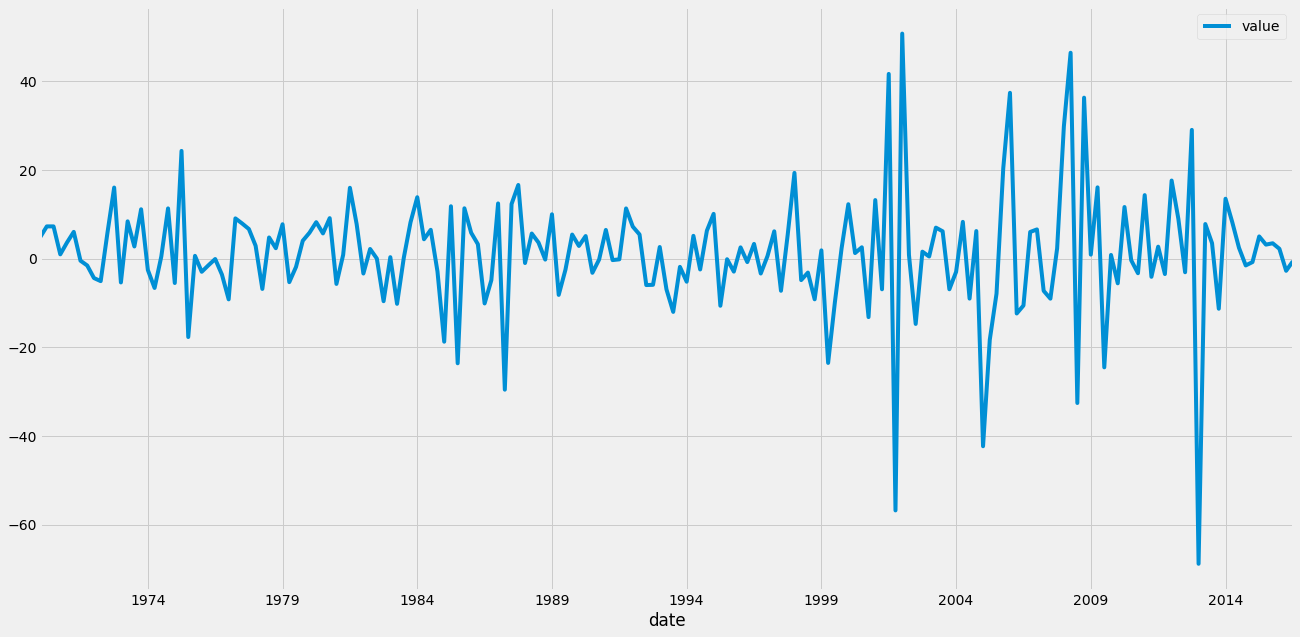

In [10]:
xdat = pd.read_csv(CFG.data_folder + 'savings_change.csv')

xdat.columns = ['date', 'value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot()

We start with a quick EDA: first, a seasonal decomposition

There is *a* seasonal component, but it is very small in magnitude; trend does not seem significant either - those are strong clues we can suspect the process is stationary and move to testing this formally (using our old acquaintance, the ADF test):

In [11]:
result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.705760
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


No red flags stopping us at this stage (reminder: this means we don't see an overall linear trend during the sample period) - we can proceed to model the series as ARMA(p,q). What about the values of p and q?

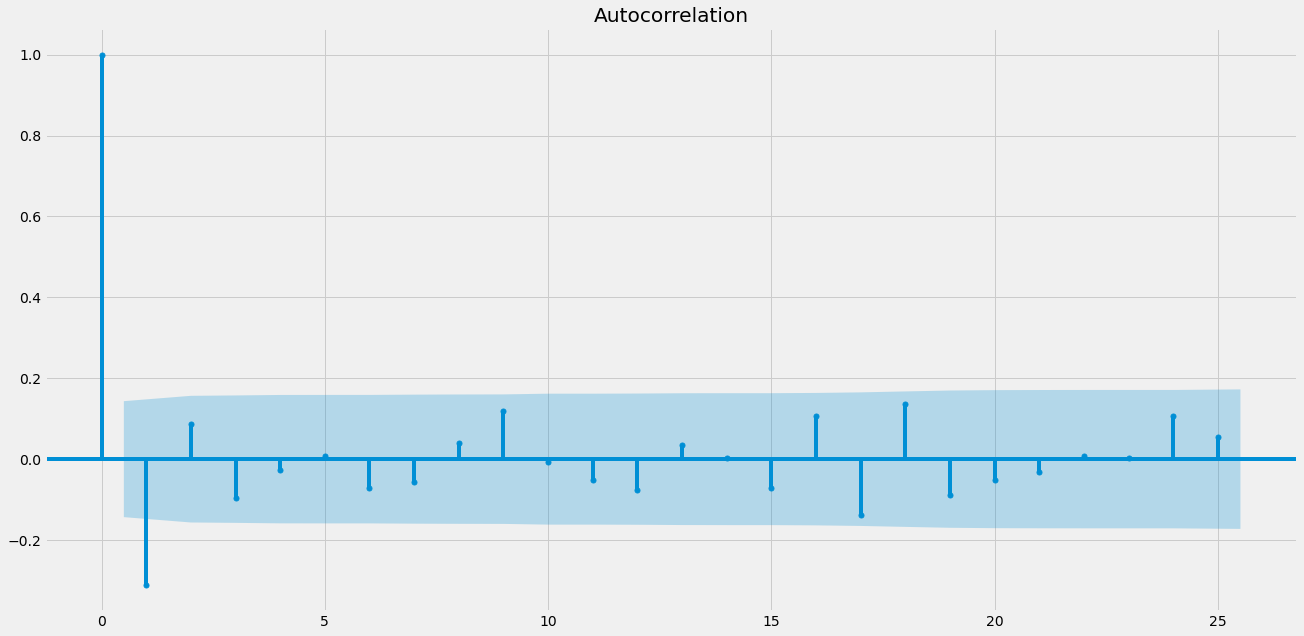

In [12]:
plot_acf(xdat['value'], lags = 25); print()

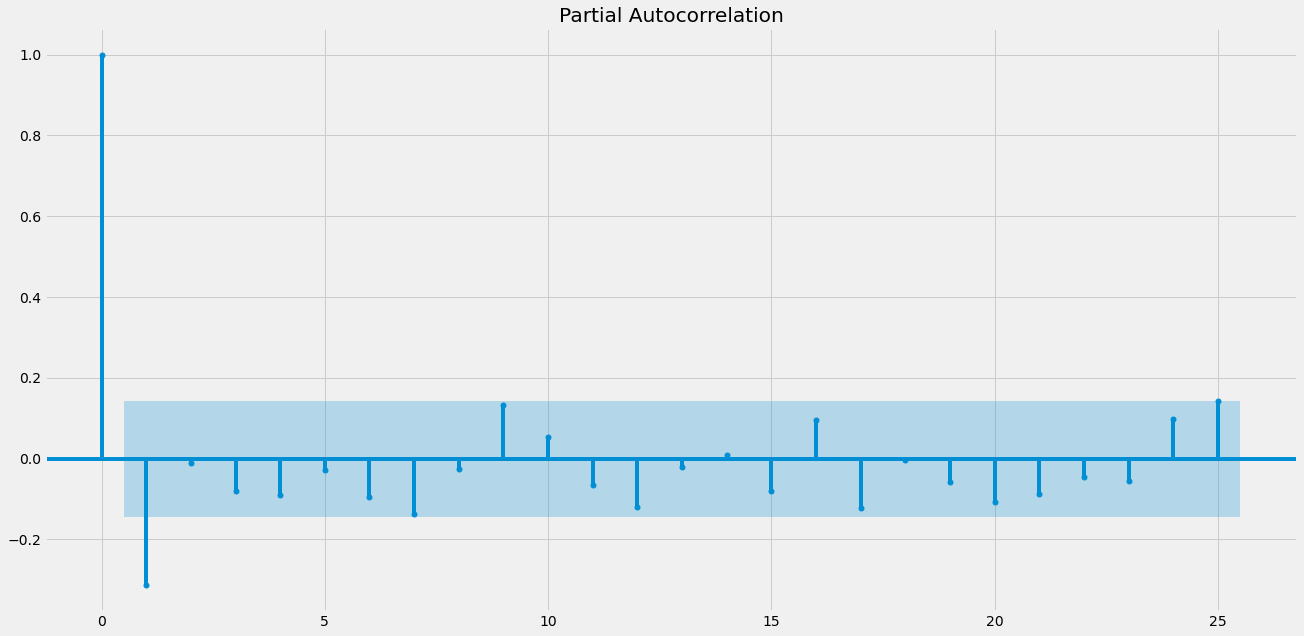

In [13]:
plot_pacf(xdat['value'], lags = 25); print()

Based on the behavior of the ACF and PACF, ARMA(3,0) does seem like a reasonable first pass. Let's split the data into training and validation:

In [14]:
x0,x1 = xdat.loc[xdat.date < '2014-01-01']['value'],  xdat.loc[xdat.date >= '2014-01-01']['value']

Next step is specifying the functional form of the model: for now, we focus on two arguments - endog (the data series we are fitting the model on) and order (specifying the $p$ and $q$ parameters). Stationarity and invertibility enforcement are related the discussion above, i.e. the conditions under which models can be flipped between representations, and can be left at default settings in most situations. Once instantiated, we simply call a $.fit$ method.

In [15]:
# We specify the model 
mod = sm.tsa.statespace.SARIMAX(endog = x0, order=(3, 0, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity= False,
                                enforce_invertibility=False
                               )

# fit
results = mod.fit()

Statsmodels provides us with a rich set of descriptive measures characterizing the fitted model:
* the top table summarizes sample size, likelihood and the information criteria - this is helpful if we want to select models on parsimony. For those unfamiliar with the topic, information criteria (AIC, BIC, HQIC and others) quantify the basic idea of balancing model complexity (number of parameters) and likelihood, so that we end up selecting a model which has the minimal number of parameters necessary to capture the details of our DGP, but not more than that:https://en.wikipedia.org/wiki/Akaike_information_criterion. An information criterion measures how well a model fits the data while taking into account the overall complexity - model that fits the data very well while using large number of parameters will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. 

* the middle table gives the estimated coefficients of the model: $ar.L_{i}$ corresponds to the coefficient of the AR part at lag $i$, which $sigma2$ is the variance of the noise component. The $Z$ statistic and the endpoints of a confidence interval allow for a quick assessment of statistical significance

* finally, the box at the bottom summarizes some diagnostic test: Jarque-Bera is used for testing if the residuals of the model have Gaussian distribution, while Ljung-Box checks whether the results are serially independent. In our case the former indicates no problem, while L-B indicates there is some serial dependence in the residuals of our model, indicating there is some component of the dynamics we are not capturing. 

In [16]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  176
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -694.762
Date:                Mon, 13 Sep 2021   AIC                           1397.524
Time:                        22:14:07   BIC                           1410.137
Sample:                             0   HQIC                          1402.641
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3069      0.047     -6.505      0.000      -0.399      -0.214
ar.L2         -0.0197      0.070     -0.282      0.778      -0.157       0.117
ar.L3         -0.0668      0.069     -0.975      0.3

The diagnostics can also be summarized visually - the graphs are pretty self-explanatory ('correlogram' is simply ACF in signal processing parlance):

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


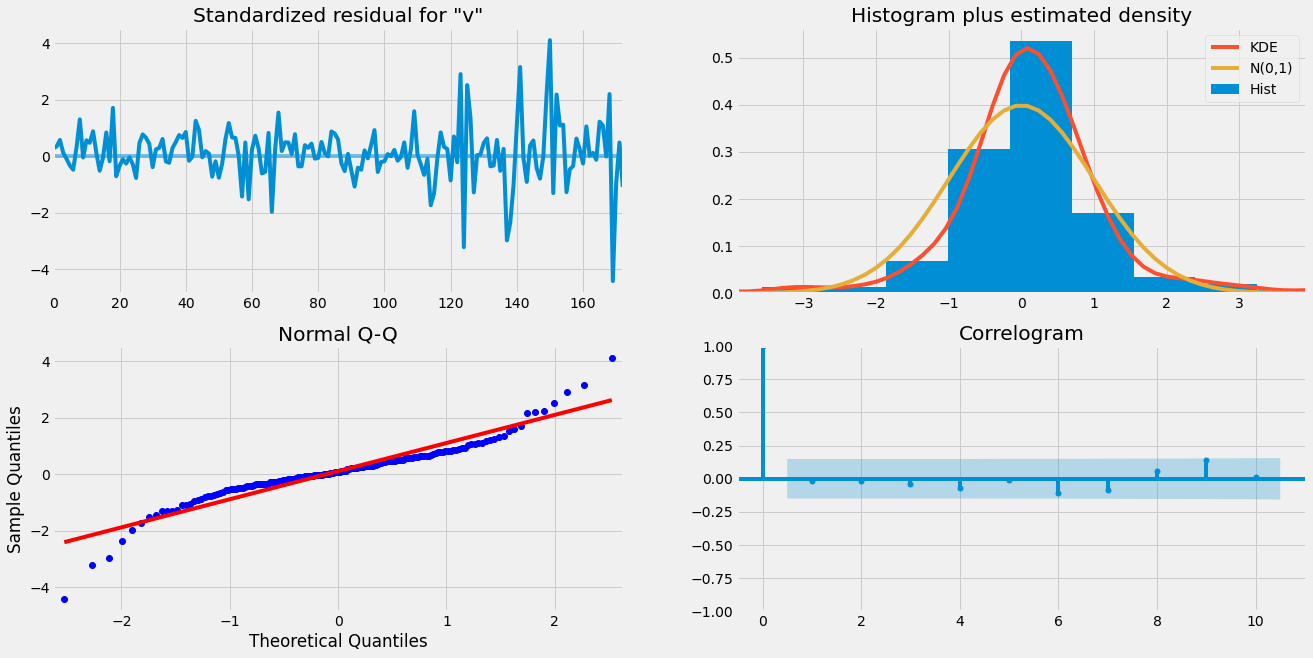

In [17]:
results.plot_diagnostics(); print()

<AxesSubplot:xlabel='date'>

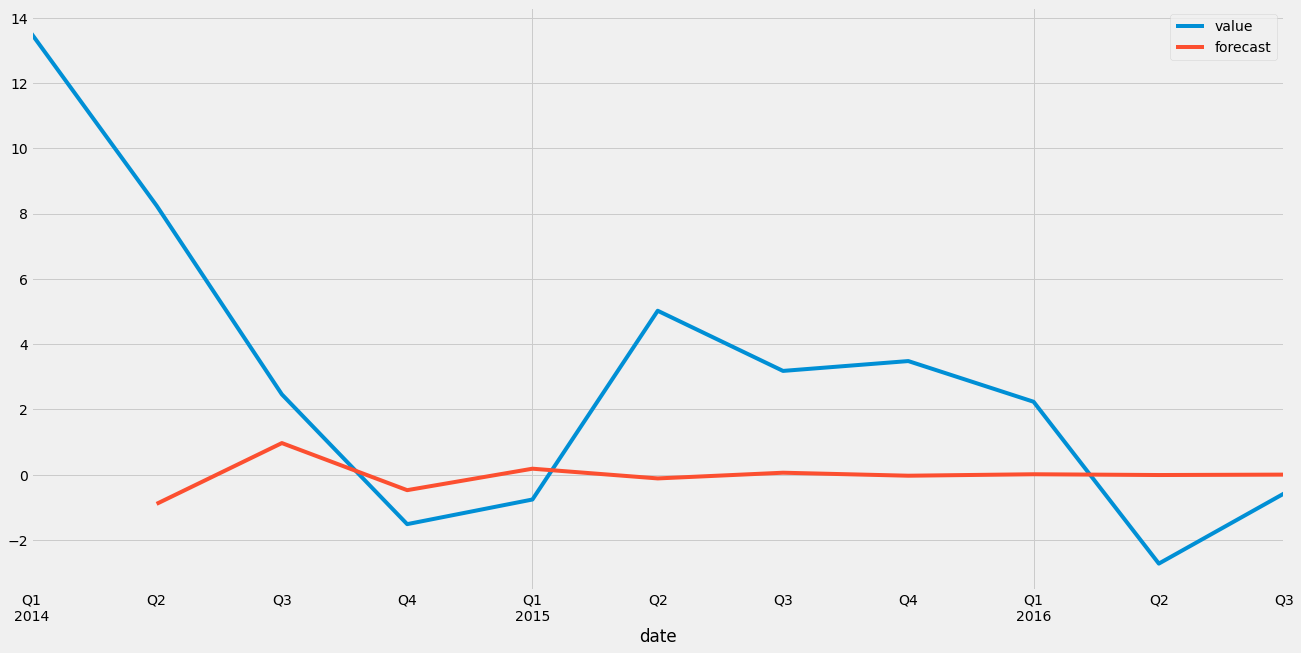

In [18]:
predictions = results.predict(start = len(x0) + 1, end  = len(x0) + len(x1) )
xpred = xdat.loc[xdat.date >= '2014-01-01'].copy()
xpred['forecast'] = predictions
xpred['date'] = pd.to_datetime(xpred['date'])
xpred.set_index('date').plot()

In terms of forecast quality this model can be useful as a baseline, but overall it is clearly nothing to write home about:
1. there is a predictable lag: one period after an increase in the original series the forecast goes up as well; this is due to autoregressive nature of the model
2. the model exhibits dynamics in the first few periods of the sample and flatlines afterward - recursive nature of the forecast means that for longer time horizons, predictions are used as if they were actual observations (just as we saw with [exponential smoothing models](https://www.kaggle.com/konradb/practical-time-series-pt-2-smoothing-methods?scriptVersionId=68281131)). 




### Case 2

Let's try another example: the passenger dataset we first encountered in the context of exponential smoothing. 

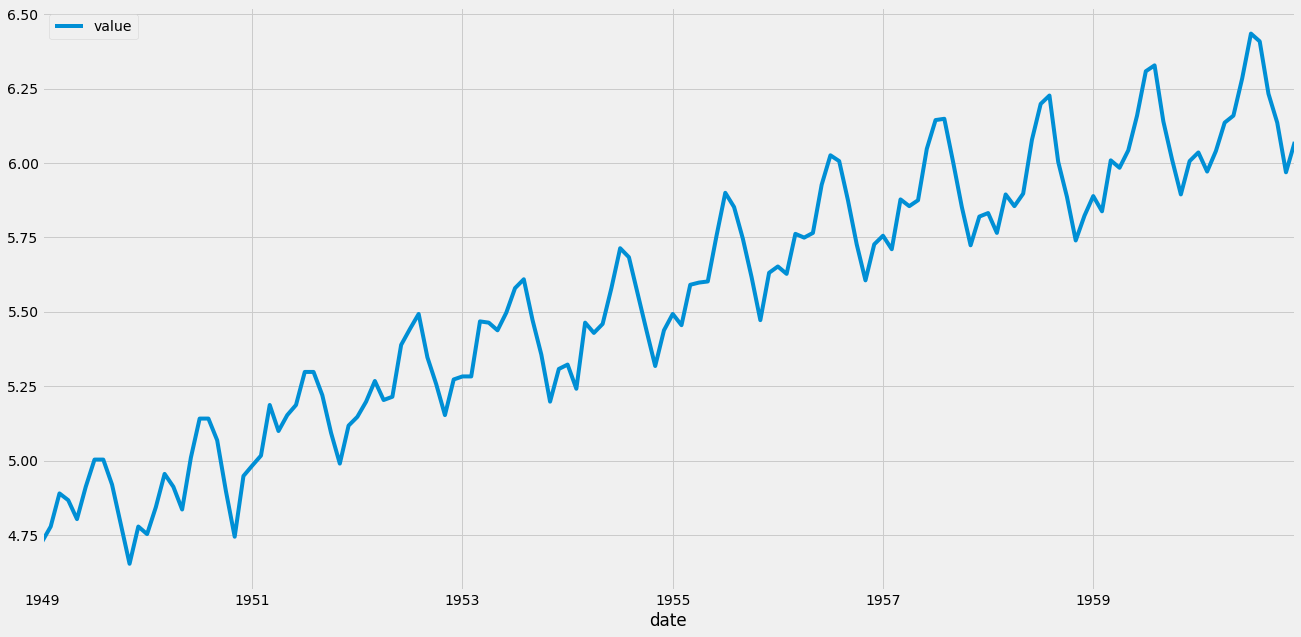

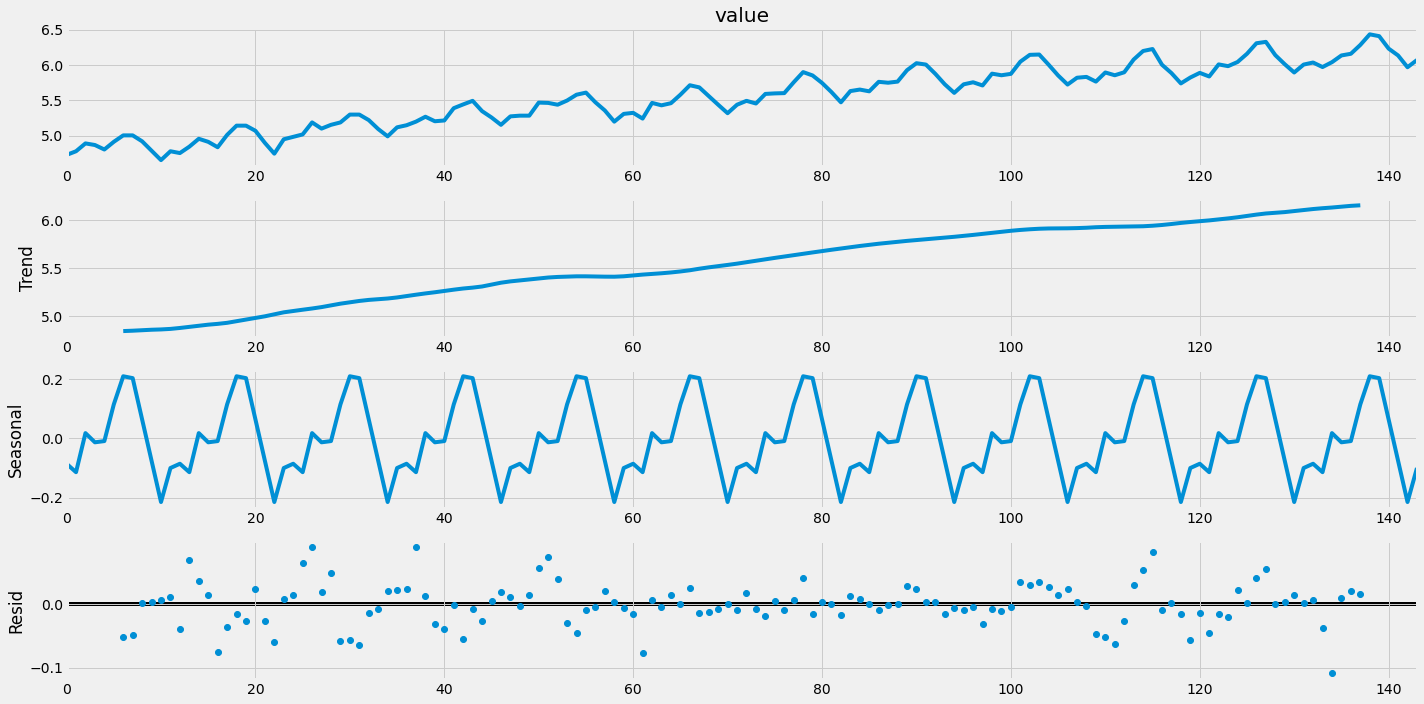

In [19]:
xdat = pd.read_csv(CFG.data_folder + 'passengers.csv')
xdat.columns = ['date', 'value']
# we will move to the log scale to avoid issues around the changing scale - recall that the definition of an ARMA model assumes 
# the variance of the noise component is constant
xdat['value'] = np.log1p(xdat['value'])
xdat['date'] = pd.to_datetime(xdat['date'])
xdat.set_index('date').plot()


decomposition = sm.tsa.seasonal_decompose(xdat["value"],period = 12) 
figure = decomposition.plot()
plt.show()


# prepare the train / test split
cutoff = '1958-01-01'
x0,x1 = xdat.loc[xdat.date < cutoff]['value'],  xdat.loc[xdat.date >= cutoff]['value']



Let us begin by fitting a model as-is - ignoring the obvious fact that the model has a clear trend component, so most certainly will not be stationary.

<AxesSubplot:xlabel='date'>

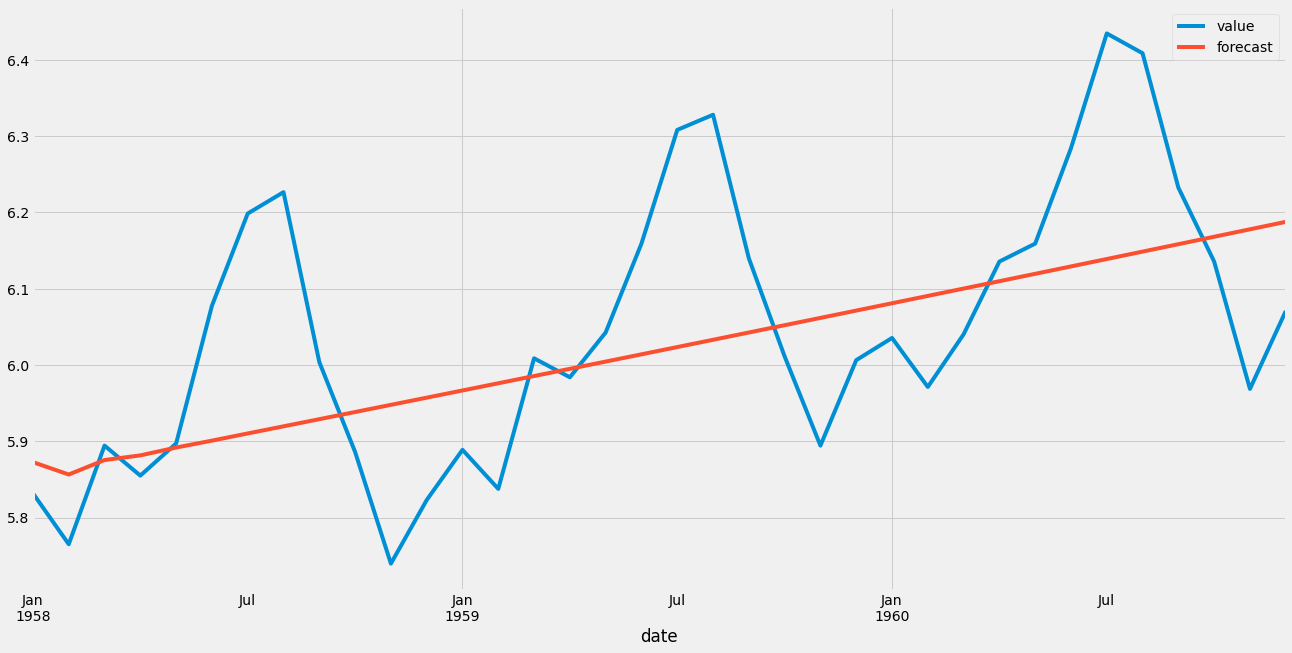

In [20]:

mod = sm.tsa.statespace.SARIMAX(endog = x0, order=(3, 0, 1), seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity= False,  enforce_invertibility=False
                               )

# fit
results = mod.fit()

# plot the predictions
predictions = results.predict(len(x0), len(xdat)  - 1)
xpred = xdat.loc[xdat.date >= cutoff].copy()
xpred['forecast'] = predictions
xpred['date'] = pd.to_datetime(xpred['date'])
xpred.set_index('date').plot()


The general direction of the forecast seems in line with the change in the data, but this directional correctness is the most positive thing to say. 

<a id="section-two"></a>
# Beyond ARMA

As we can see from the examples above, there are issues when applying the baseline $ARMA(p,q)$ model to real life time series:
* the models are only efficient if the series is stationary - peformance deteriorates rapidly otherwise 
* does not allow for trend
* does not allow for seasonality

The last two issues can be handled by differencing the series at appropriate lags, and it is this idea that allows us to extend ARMA - first, we move towards ARIMA. 

### ARIMA

A process $X_t$ is ARIMA(p,d,q) $\iff$ $\nabla^d X_t$ is ARMA(p,q)

Unpacking the (slightly cryptic :-) formulation: 
* a series becomes a stationary ARMA(p,q) after differencing it $d$ times

* discrete version of differentiation: polynomial of order $d$ becomes a constant after taking $d$th derivative

* non-seasonal ARIMA encapsulates other models as special cases
  - ARIMA(0,0,0) is white noise
  - ARIMA(0,1,0) is random walk
  - ARIMA(p,0,0) is AR(p)
  - ARIMA(0,0,q) is MA(q)
  
  
The basic idea is that if we are dealing with a series that can be represented as a stationary process with polynomial trend, we can model it jointly (instead of manually differencing $d$ times and then flipping back). 

### SARIMA

The "I" in ARIMA corresponds to the "integrated" component, which is a formal way of saying we are incorporating the trend into our setup starting with a stationary $ARMA(p,q)$ process. Following a similar logic, we can incorporate the seasonal component and allow it to follow the same type of dynamic: a seasonal ARIMA (SARIMA) model can be denoted as ARIMA(p,d,q)(P,D,Q)m, where:
- m refers to the number of periods in each season
- (lowercase) p,d,q refer to the definition of the ARIMA part
- (uppercase) P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model.

While not obvious on an intuitive level, the SARIMA model is easier to understand if we make use of the backshift (lag) operator (https://en.wikipedia.org/wiki/Lag_operator). If we have a model for quarterly data, 


The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period. For example, an $ARIMA(1,1,1)(1,1,1)_4$ model  is for quarterly data (m = 4) series $y_t$ can be specified as 
    \begin{equation}       
    (1 - \phi_1 B)(1- \Phi_1 B^4)(1- B)(1-B^4)y_t = (1 + \theta_1 B)(1 + \Theta_1 B)\epsilon_t
    \end{equation}

For a proper exposition, with examples in R, the reader is encouraged to read Rob Hyndman's online book: https://otexts.com/fpp2/seasonal-arima.html

### SARIMAX

While not a very common situation, we do have data available for the forecast horizon (for example long term economic forecasts, which are available in advance). This means we can use **exogenous** variables to improve the quality of the forecast - hence SARIMA**X**.


<a id="section-three"></a>
# Full pipeline

We are in a position to combine all the building blocks and solve a real-life problem in full generality. We will the Superstore dataset (a version can be found here: https://www.kaggle.com/bravehart101/sample-supermarket-dataset). 

In [21]:
df = pd.read_excel(CFG.data_folder + "Sample - Superstore.xls")
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


There is quite a lot of information here, most of which is not needed for our purposes - so let's clean it up a bit. 

In [22]:
# we pick only a single category of purchases
df = df.loc[df['Category'] == 'Furniture']
# remove the unnecessary columns
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')
df.head(10)

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940
4938,2014-01-13,333.999
6474,2014-01-14,61.960
970,2014-01-16,127.104
5465,2014-01-19,181.470
6327,2014-01-20,272.940


In [23]:
# check the time range we are looking at
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

With four years worth of data, we can think about capturing seasonal patterns (always worth remembering: modeling seasonal effects makes sense if you have at least two complete data cycles in your dataset).

Unlike some other models we will discuss in subsequent parts of this series (Kalman filter being a prominent example), ARIMA models require regularly sampled observations and do not work with missing values. Let's ensure our dataset satisfies those requirements:

<AxesSubplot:xlabel='Order Date'>

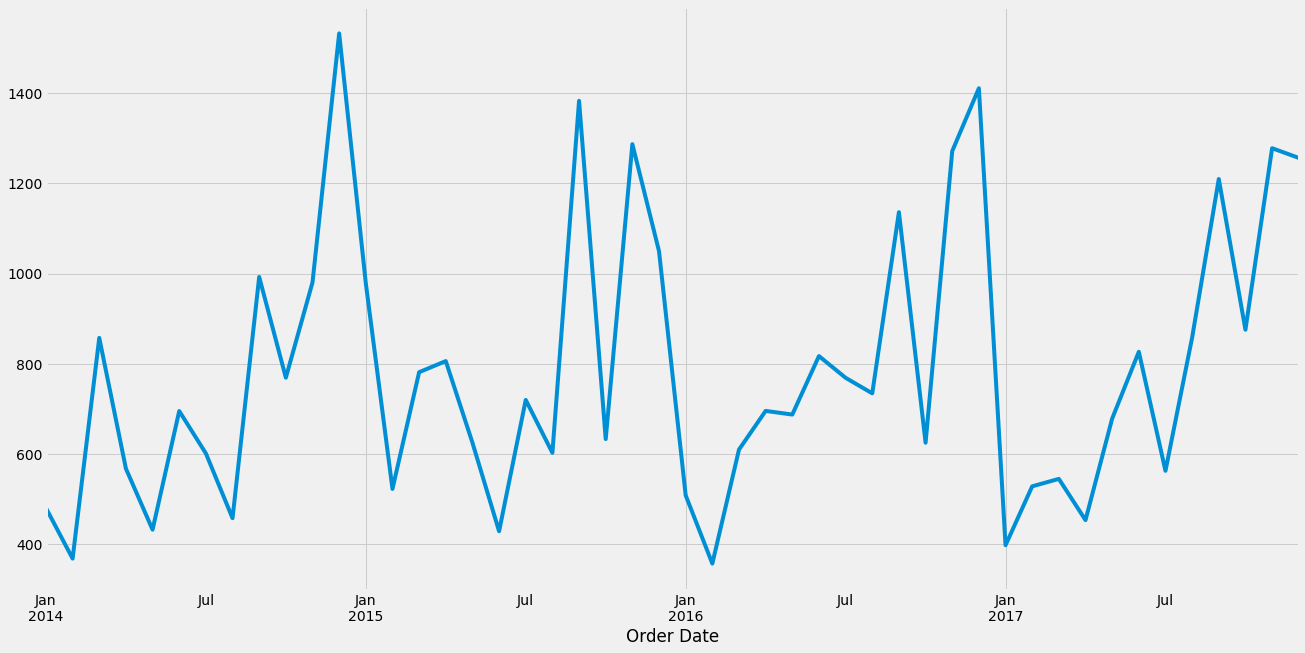

In [24]:

# we have multiple transactions per day => we need to aggregate the data
df = df.groupby('Order Date')['Sales'].sum().reset_index()

# set index for easier manipulation
df = df.set_index('Order Date')

# as shown above, some days are missing => we resample the data to a monthly frequency
df = df['Sales'].resample('MS').mean()

# examine the results
df.plot()

There's definitely some seasonality, possibly trend? We can have a closer look using the seasonal decomposition:

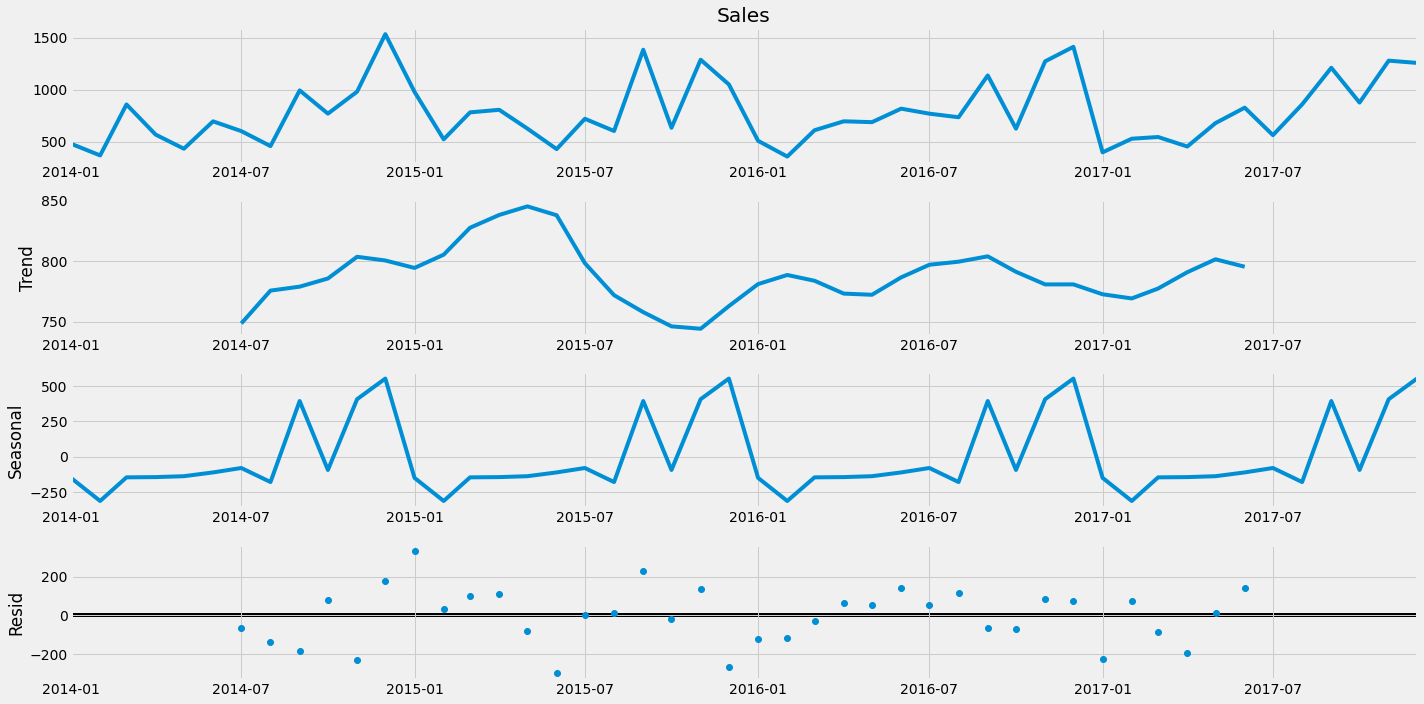

In [25]:

# basic decomposition 
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
# plt.show()

Let's use start of 2017 as cutoff, so we use the period up until the end of 2016 as training data:

In [26]:
x0, x1 = df[:'2016'], df['2017':]

In [27]:
# check stationarity
result = adfuller(x0)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.297939
p-value: 0.000448


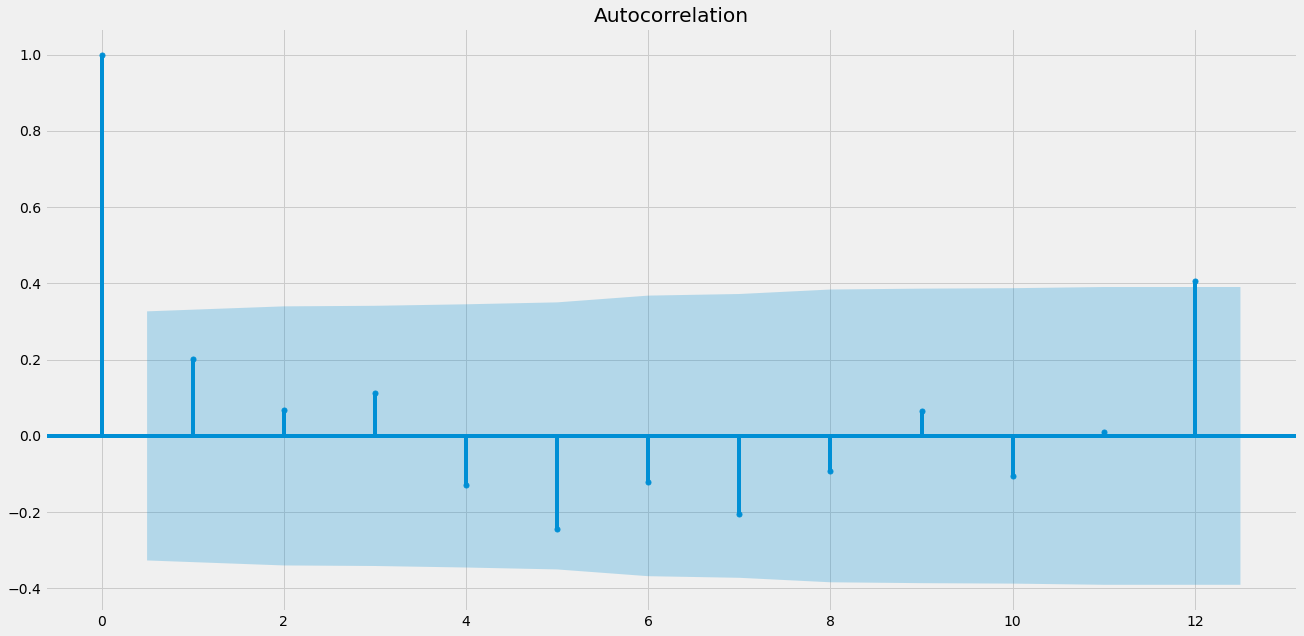

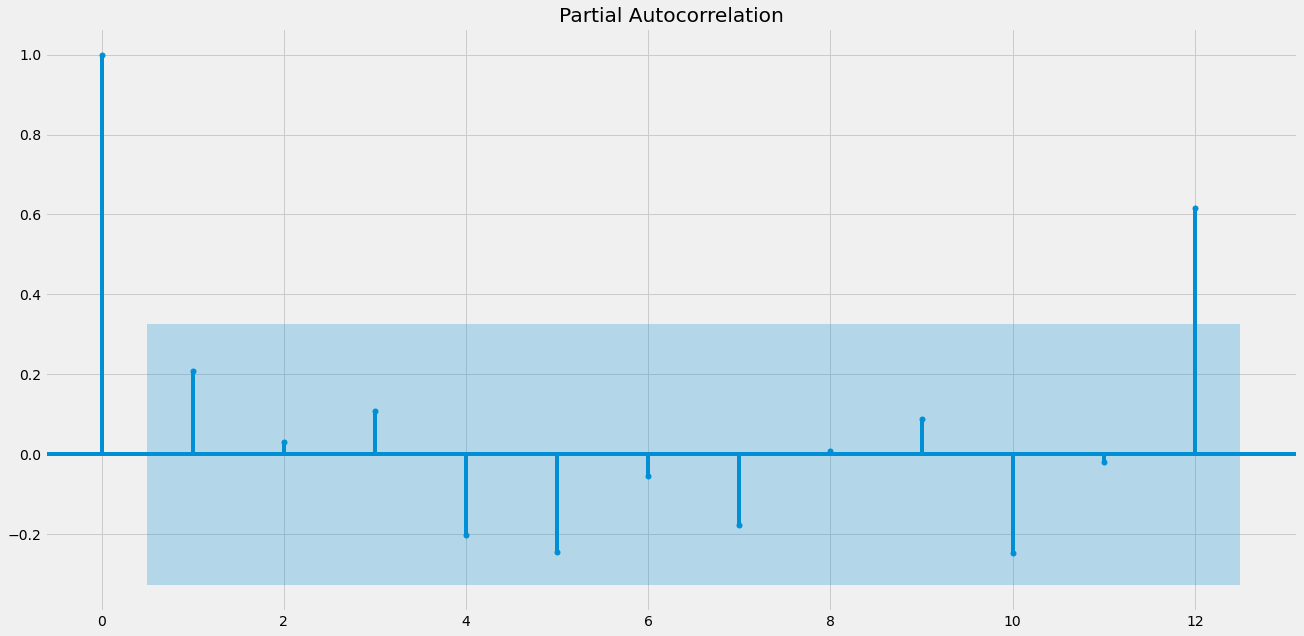

In [28]:
# examine autocorrelation
plot_acf(x0, lags = 12); print()
plot_pacf(x0, lags = 12); print()

Nothing stands out (pun intended) except lag 12 - what about the version differenced thus? If we are talking about monthly sales data, it reasonable for such serial dependence to persist in raw data, but disappear with seasonal differencing. 

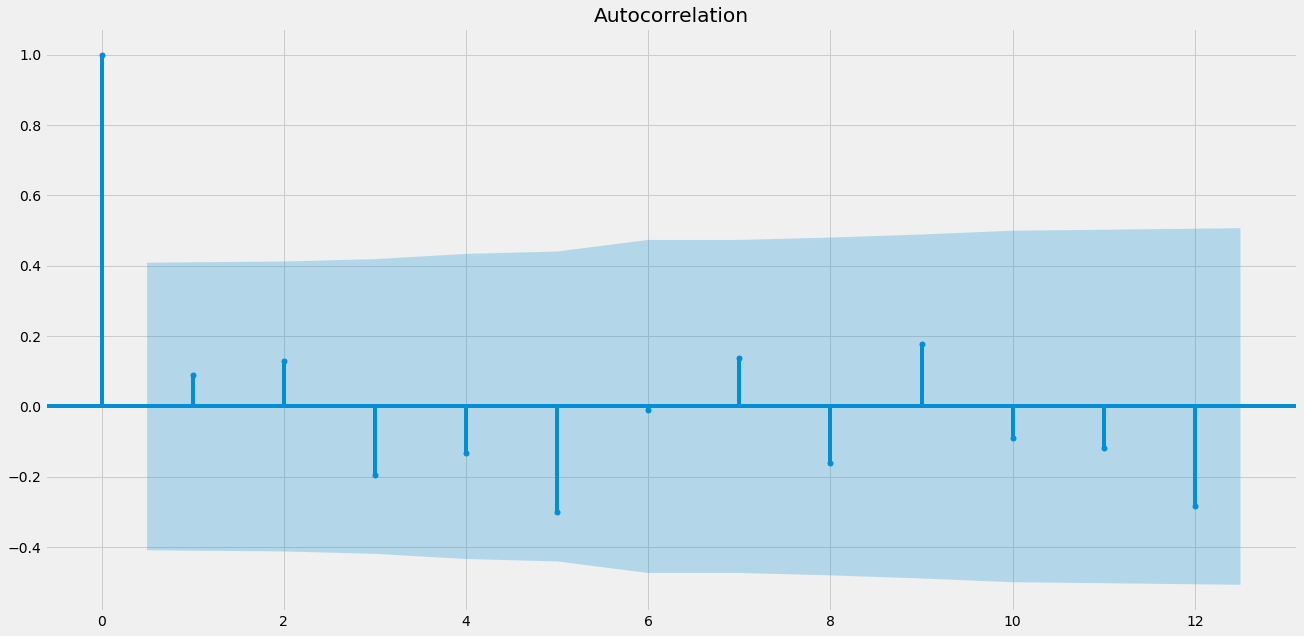

In [29]:

plot_acf(x0.diff(12)[13:], lags = 12); print()

Indeed it does. We could use this guesstimate for our model, but we can do something else: evaluate different possible combinations of parameters (effectively replicating the functionality from R wrapped in the `auto.arima` function - I copied this chunk from https://medium.com/mlearning-ai/sarima-vs-prophet-forecasting-time-series-b121e1e2bd37):

In [30]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]
print('Parameter combinations for Seasonal ARIMA...')
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(x0, order=param,)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:588.9104247508972
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:566.1089155394645
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:566.1089155394645
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:515.4250585951503
ARIMA(0, 1, 0)x(0, 0

Fit the model with optimal parameters:

In [31]:
# Fit model
mod = sm.tsa.statespace.SARIMAX(x0,
                                order=(0,1,1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0640      0.475     -0.135      0.893      -0.996       0.868
ar.S.L12      -0.3412      0.501     -0.681      0.496      -1.322       0.640
ma.S.L12      -0.9973      0.955     -1.044      0.296      -2.869       0.874
sigma2      1.313e+04   7.29e-05    1.8e+08      0.000    1.31e+04    1.31e+04


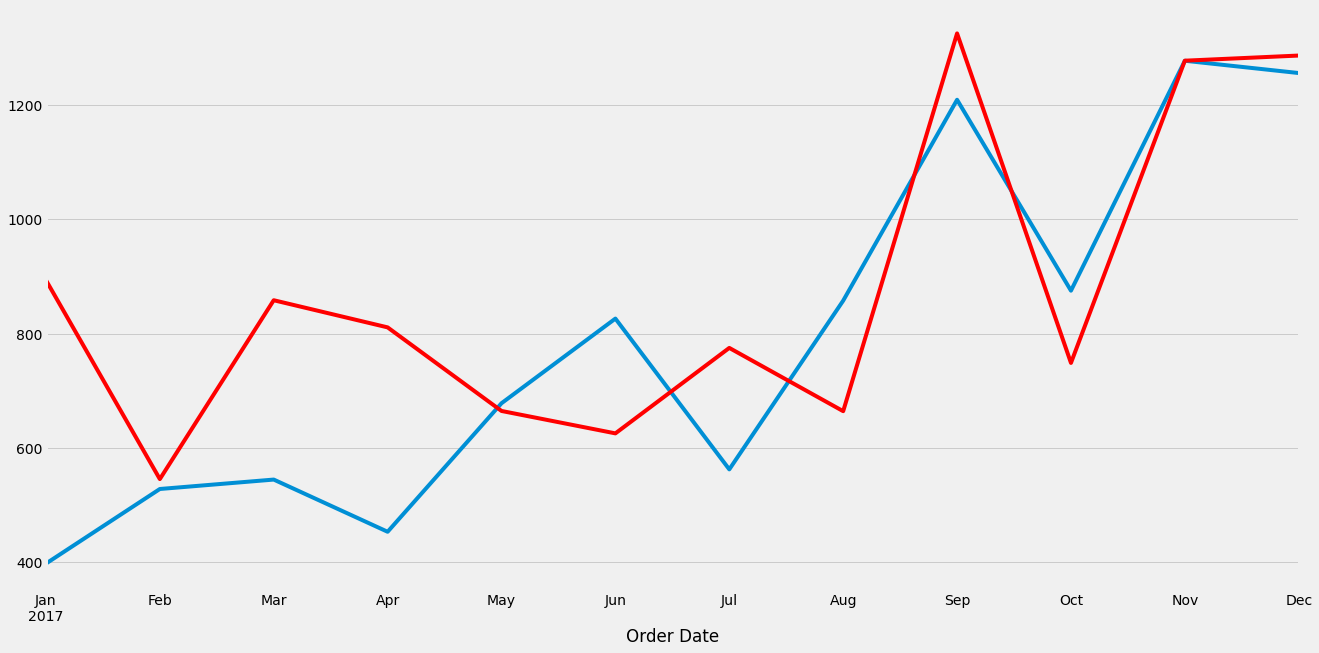

In [32]:
# plot the forecast
yhat = results.predict(x0.shape[0],x0.shape[0] + x1.shape[0] - 1)
x1.plot()
yhat.plot(color = 'red')
plt.show()

This part took a while to land - going on vacation and coding do not exactly match, at least for me :-) In the next installment, we will talk about state space models: a general class of time series models which combine the speed of exponential smoothing with the generalization of ARMA. Stay tuned!
